![Banner logo](https://raw.githubusercontent.com/CitrineInformatics/community-tools/master/templates/fig/citrine_banner_2.png)

# Citrination t-SNE API

*Authors: Erin Antono, Enze Chen*

In this tutorial, we're going to learn to use Citrination to generate a useful data analysis called t-SNE. This data visualization technique enables you to represent a high dimensional set of data in fewer dimensions in a way that preserves the local structure of the data. In materials informatics, this allows you to create a two-dimensional plot of a set of materials where points corresponding to similar materials are grouped together in two-dimensional space. More information on t-SNE here: https://lvdmaaten.github.io/tsne/

This tutorial will teach you to create and export a two-dimensional t-SNE plot for any data on Citrination. The first step is to create a [data view on Citrination](https://citrination.com/data_views). We have instructions for doing so through the [UI](../citrination_ui_examples/03_data_views.md) and [API](clients_sequence/2_data_views_client_api_tutorial.ipynb).

We'll be using [this data view](https://citrination.com/data_views/4106) (view id `4106`) for this tutorial, which includes a model predicting experimental band gaps based on data compiled by W.H. Strehlow and E.L. Cook, which can be viewed in [this dataset](https://citrination.com/datasets/1160/show_search).

## Python package imports

In [1]:
# Standard packages
import os

# Third-party packages
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from citrination_client import CitrinationClient

## Get the t-SNE projections

In [2]:
# Initialize the CitrinationClient 
client = CitrinationClient(
    api_key=os.environ["CITRINATION_API_KEY"],
    site="https://citrination.com" # public
)

tsne_view_id = "4106"
tsne = client.models.tsne(tsne_view_id)

print(tsne.projections())

dict_keys(['Property Color', 'Property Band gap'])


The `tsne` call returns a dictionary where the top level keys correspond to the properties that are being modeled. In this data view, the model inputs are `Chemical formula` and `Crystallinity`. Citrination represents a chemical formula by calculating over 50 material descriptors. The t-SNE plot reduces that into just 2 dimensions. Let's look at the t-SNE plot for `Band gap`.

In [3]:
[x for x in dir(tsne.get_projection("Property Band gap")) if not x.startswith('_')]

['responses', 'tags', 'uids', 'xs', 'ys']

- `x` is the x component of the t-SNE plot
- `y` is the y component of the t-SNE plot
- `z` is the property value (Band gap in this example)
- `uid` is the uid of the record on Citrination. You can find the record by going to https://citrination.com/pif/{uid}
- `label` is the list of the values of the model inputs for the record

## Plot the t-SNE projection

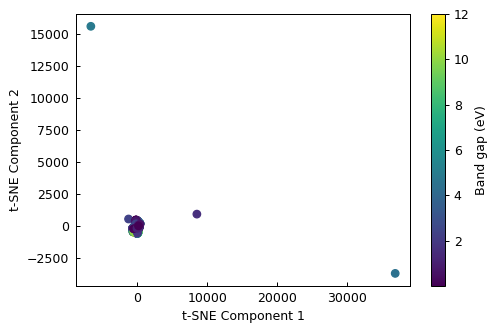

In [4]:
gap_projection = tsne.get_projection("Property Band gap")

#plot results
fig = plt.figure(dpi=90)
ax = fig.subplots()

plot = ax.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(plot, label="Band gap (eV)")

#image formatting
ax.tick_params(direction='in', pad=5)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")

plt.show()

When interpreting a t-SNE plot, keep in mind that the t-SNE components plotted on the $x$ and $y$ axes have no physical meaning. Since the t-SNE algorithm preserves the local structure of the data, we look at points that end up close together. Just from looking at the plot, we can see that there are a few clusters of materials; let's take a look at what those materials are.

(Note: t-SNE is a non-deterministic algorithm, so the plot will change if the underlying Data View is retrained)

## Inspect candidates of interest more closely

In [5]:
# Load the coordinates and band gap values into a numpy array
coordinates_and_bg = np.array(
    [gap_projection.xs, gap_projection.ys, gap_projection.responses]
    ).transpose()

In [6]:
# Find the n materials closest to the target material, as specified by index
# based on cartesian distance in the t-SNE coordinates
def find_most_similar_materials(index, coordinates, n_materials=10):
    distances = np.linalg.norm(coordinates_and_bg[:,0:2] - coordinates_and_bg[index,0:2], axis=1)
    return np.argsort(distances)[1:n_materials+1]

From inspecting this cluster of materials, we can see that the t-SNE plot has grouped highly ionic materials together, and that these materials have very high band gaps.

,Material,Band Gap,URL
Max,"Yellow, Single crystalline, 12.0, InorganicChemicalFormula(LiF)",12.0,link


,Material,Band Gap,URL
0,"10.5, InorganicChemicalFormula(NaF)",10.50,link
1,"Yellow, Single crystalline, 10.0, InorganicChemicalFormula(CaF2)",10.00,link
2,"Red, Single crystalline, 9.06, InorganicChemicalFormula(BaF2)",9.06,link
3,"Yellow, Single crystalline, 11.8, InorganicChemicalFormula(MgF2)",11.80,link
4,"Yellow, Single crystalline, 10.3, InorganicChemicalFormula(KF)",10.30,link
5,"Red, Single crystalline, 6.6, InorganicChemicalFormula(LaF3)",6.60,link
6,"Red, Single crystalline, 10.4, InorganicChemicalFormula(RbF)",10.40,link
7,"Red, Single crystalline, 6.0, InorganicChemicalFormula(CdF2)",6.00,link
8,"Red, Polycrystalline, 5.3, InorganicChemicalFormula(PrF3)",5.30,link
9,"Red, Polycrystalline, 10.0, InorganicChemicalFormula(CsF)",10.00,link


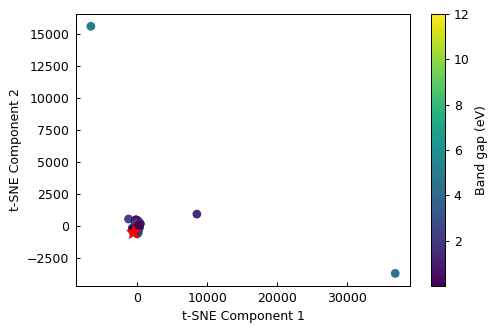

In [7]:
# Get the index of the maximum band gap material
max_bg_index = np.argmax(coordinates_and_bg, axis=0)[2]

max_bg_material = HTML(pd.DataFrame({
    "Material":gap_projection.tags[max_bg_index],
    "Band Gap": gap_projection.responses[max_bg_index],
    "URL": '<a target="_blank" href="https://citrination.com/pif/{}">link</a>'.format(gap_projection.uids[max_bg_index])
    }, index=["Max"]).to_html(escape=False))

display(max_bg_material)

indexes = [idx for idx in find_most_similar_materials(max_bg_index, coordinates_and_bg[:,0:2])]

similar_bg_materials = HTML(pd.DataFrame({
    "Material": [gap_projection.tags[idx] for idx in indexes],
    "Band Gap": [gap_projection.responses[idx] for idx in indexes],
    "URL": ['<a target="_blank" href="https://citrination.com/pif/{}">link</a>'.format(gap_projection.uids[idx]) for idx in indexes]
    }).to_html(escape=False))

display(similar_bg_materials)

#plot results
fig = plt.figure(dpi=90)
ax = fig.subplots()

gap_projections = ax.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(gap_projections, label="Band gap (eV)")

max_gap_projection = ax.scatter(coordinates_and_bg[max_bg_index, 0], coordinates_and_bg[max_bg_index, 1],
            marker="*", c="r", s=120)

#image formatting
ax.tick_params(direction='in', pad=5)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")

plt.show()

Now let's figure out what material the outlier point with the largest y-value corresponds to

,Material,Band Gap,URL
Outlier,"Red, Single crystalline, 4.9, InorganicChemicalFormula(PrB6)",4.9,link


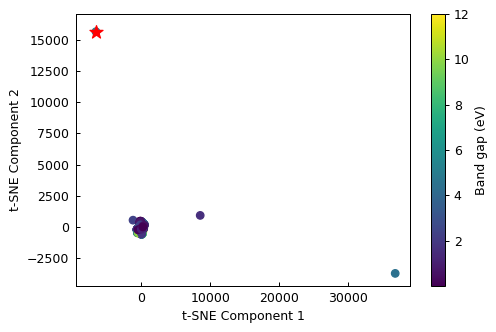

In [13]:
outlier_index = np.argmax(coordinates_and_bg, axis=0)[1]

outlier_material = HTML(pd.DataFrame({
    "Material":gap_projection.tags[outlier_index],
    "Band Gap": gap_projection.responses[outlier_index],
    "URL": '<a target="_blank" href="https://citrination.com/pif/{}">link</a>'.format(gap_projection.uids[outlier_index])
    }, index=["Outlier"]).to_html(escape=False))

display(outlier_material)

#plot results
fig = plt.figure(dpi=90)
ax = fig.subplots()

gap_projections = ax.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(gap_projections, label="Band gap (eV)")
outlier_y = ax.scatter(coordinates_and_bg[outlier_index, 0], coordinates_and_bg[outlier_index, 1],
            marker="*", c="r", s=120)

#image formatting
ax.tick_params(direction='in', pad=5)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")

plt.show()

We can also find materials that are similar to a given material in the dataset. Let's find materials similar to HgSe https://citrination.com/datasets/1160/version/3/pif/F7DF9D76620C95CD45BD41881D96E174. The uid comes in the format dataset_id/version/pif_id. For HgSe, the uid is 1160/3/F7DF9D76620C95CD45BD41881D96E174.

,Material,Band Gap,URL
$HgSe$,"Red, Single crystalline, 0.07, InorganicChemicalFormula(HgSe)",0.07,link


,Material,Band Gap,URL
0,"Gray, Single crystalline, 0.175, InorganicChemicalFormula(HgTe)",0.175,link
1,"Gray, Single crystalline, 1.517, InorganicChemicalFormula(CdTe)",1.517,link
2,"Yellow, Single crystalline, 1.865, InorganicChemicalFormula(CdSe)",1.865,link
3,"Red, Single crystalline, 2.095, InorganicChemicalFormula(HgS)",2.095,link
4,"Red, Single crystalline, 2.34, InorganicChemicalFormula(ZnTe)",2.340,link
5,"Gray, Single crystalline, 0.428, InorganicChemicalFormula(CdSb)",0.428,link
6,"Red, Single crystalline, 2.37, InorganicChemicalFormula(Hg2I2)",2.370,link
7,"Yellow, Single crystalline, 2.67, InorganicChemicalFormula(ZnSe)",2.670,link
8,"Red, Single crystalline, 0.59, InorganicChemicalFormula(ZnSb)",0.590,link
9,"Red, Single crystalline, 2.6, InorganicChemicalFormula(Hg2Br2)",2.600,link


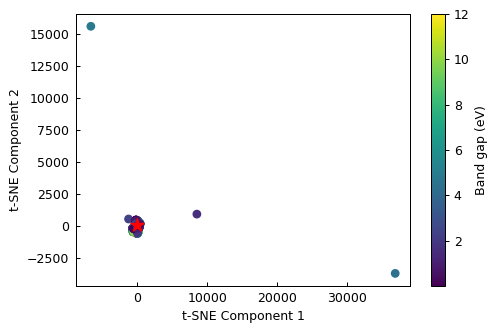

In [10]:
uid = '1160/3/F7DF9D76620C95CD45BD41881D96E174'
HgSe_index = gap_projection.uids.index(uid)

HgSe = HTML(pd.DataFrame({
    "Material":gap_projection.tags[HgSe_index],
    "Band Gap": gap_projection.responses[HgSe_index],
    "URL": '<a target="_blank" href="https://citrination.com/pif/{}">link</a>'.format(gap_projection.uids[HgSe_index])
    }, index=["$HgSe$"]).to_html(escape=False))

display(HgSe)

indexes = [idx for idx in find_most_similar_materials(HgSe_index, coordinates_and_bg[:,0:2])]

similar_materials = HTML(pd.DataFrame({
    "Material": [gap_projection.tags[idx] for idx in indexes],
    "Band Gap": [gap_projection.responses[idx] for idx in indexes],
    "URL": ['<a target="_blank" href="https://citrination.com/pif/{}">link</a>'.format(gap_projection.uids[idx]) for idx in indexes]
    }).to_html(escape=False))

display(similar_materials)

#plot results
fig = plt.figure(dpi=90)
ax = fig.subplots()

gap_projections = ax.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(gap_projections, label="Band gap (eV)")
cr3se4_plot = ax.scatter(coordinates_and_bg[HgSe_index, 0], coordinates_and_bg[HgSe_index, 1],
            marker="*", c="r", s=120)

#image formatting
ax.tick_params(direction='in', pad=5)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")

plt.show()

As we've seen here, t-SNE is a useful tool for understanding materials datasets and gaining new insights by visualizing and exploring a large, high-dimensional dataset in two dimensions. In this tutorial, we've seen how to examine outliers, find interesting clusters of similar materials, and find materials that are similar to a given material, which are only some of the cool things that you can do with t-SNE plots. The t-SNE analysis is available for all real-valued outputs specified in the Data Views creation process.